
# Convolutional Neural Networks

*Emmanuel Viennet, 2020-12-07*

## Motivation

We saw in our previous experiment (see notebook `classif-MNIST-fullconnect`) that a fully connected NN with one hidden layer obtained an error rate of 2.2% on our MNIST test set.

In this notebook, let's explore a simple CNN on the same data.




In [1]:
%matplotlib inline
import os, math
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # SciPy module that loads mat-files

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load MNIST digits

Images are 28x28 pixels.

In [2]:
mnist_raw = loadmat('../../data/mnist-original.mat') # adjust path if necessary
# Assume square images:
ImWidth = int(math.sqrt(mnist_raw['data'].shape[0]))
ImHeight = ImWidth
data = torch.from_numpy(mnist_raw['data'].transpose()).view((-1,1,ImWidth,ImHeight))
print('data.shape = ', data.shape) # 70000 28x28 images
label = mnist_raw['label'].reshape(-1).astype(int)

data.shape =  torch.Size([70000, 1, 28, 28])


In [3]:
# Normalization parameters, computed on all data (train+test)
data_float = data.to(torch.float)
mean_pixel = torch.mean(data_float)
std_pixel = torch.std(data_float)
print(f'mean_pixel={mean_pixel}, std_pixel={std_pixel}')

mean_pixel=33.377349853515625, std_pixel=78.65437316894531


In [4]:
X = (data_float - mean_pixel) / std_pixel
print(f'mean input={torch.mean(X)}, std input={torch.std(X)}')

mean input=9.40883910516277e-05, std input=1.0


### Prepare output vectors in "one hot encoding" format
`label` are the classes `(0, 1, ..., 9)`.

In [5]:
Y = torch.zeros([len(X), 10], dtype=torch.float)
for i in range(len(X)):
    Y[i][label[i]] = 1.

### Shuffle the examples
During learning, the examples should be presented in a random order. 
Because if we present all the examples from class 0, then class 1, etc., the learning would not converge.

In [6]:
# Shuffle the examples:
indices_permutes = torch.randperm(len(X))
X_perm = X[indices_permutes]
Y_perm = Y[indices_permutes]
print(X_perm.size())

torch.Size([70000, 1, 28, 28])


### Split the data in train/test sets:
In this case, we learn on 2/3 of the data, and use the remaining tier to estimate the performances.

In [7]:
n_train = (len(X)*2)//3
X_train = X_perm[:n_train]
Y_train = Y_perm[:n_train]

X_test = X_perm[n_train:]
Y_test = Y_perm[n_train:]
print('Learning on', len(X_train), 'examples')
print('Eval     on', len(X_test), 'examples')

Learning on 46666 examples
Eval     on 23334 examples


In [8]:
# Get classification errors
def idx_classif_errors(Y_true, Y_pred):
    """Number of classification errors, on 2 "one hot encoded" tensors
    """
    Y_pred_cls = np.argmax(Y_pred.detach().numpy(), axis=1)
    Y_true_cls = np.argmax(Y_true.detach().numpy(), axis=1)
    return np.where(Y_pred_cls != Y_true_cls)[0]

def nb_classif_errors(Y_true, Y_pred):
    return len(idx_classif_errors(Y_true, Y_pred))


# Define the neural network


Let’s define a convolutional neural network, like LeNet-5 (see http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)

In [9]:
class LeNet5(torch.nn.Module):
     
    def __init__(self):   
        super(LeNet5, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given as input. Hence padding of 2 is done below)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        # Max-pooling
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        # Convolution
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2)
        # Fully connected layer
        self.fc1 = torch.nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = torch.nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = torch.nn.Linear(84, 10)        # convert matrix with 84 features to a matrix of 10 features (columns)
        
    def forward(self, x):
        # convolve, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.conv1(x))  
        # max-pooling with 2x2 grid
        x = self.max_pool_1(x)
        # convolve, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x = x.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        
        return x

In [40]:
net = LeNet5()
print(net)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Loss function and optimizer

In [41]:
# set up loss function -- 'SVM Loss' a.k.a ''Cross-Entropy Loss
loss_func = torch.nn.CrossEntropyLoss()  
# SGD used for optimization, momentum update used as parameter update   
optimizer = torch.optim.SGD(net.parameters(), lr = 0.001, momentum=0.9) 

# Learning the Network

In [42]:
batch_size = 30
num_epochs = 30

losses = [] # record losses and error rates during learning
train_err_rates = []
test_err_rates = []

In [43]:
# Learning loop
for epoch in range(num_epochs):
    print("starting epoch", epoch)
    for beg_i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[ beg_i:beg_i + batch_size, :]
        y_batch = Y_train[ beg_i:beg_i + batch_size]        
        # forward:
        outputs = net(x_batch)
        loss = loss_func(outputs, np.argmax(y_batch, axis=1)) # note that CrossEntropyLoss requires class index, not one-hot-encoding
        # reset gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())
        if (beg_i//batch_size) % 1000 == 0: 
            # print cost after 1000 updates (mini-batches):
            # this is the cost on the last seen mini-batch, hence noisy !
            print(beg_i, 'loss=%3.3g' % losses[-1])
    
    # Measure error rate after each epoch
    train_nb_err = nb_classif_errors( Y_train, net(X_train) ) 
    train_err_rates.append( train_nb_err*100/len(Y_train) )
    test_nb_err = nb_classif_errors( Y_test, net(X_test) ) 
    test_err_rates.append( test_nb_err*100/len(Y_test) )
    print("Nb of errors (training set):", train_nb_err, "(%3.2g%%)" % train_err_rates[-1])
    print("Nb of errors (test set):", test_nb_err, "(%3.2g%%)" % test_err_rates[-1])


print("Done.")

starting epoch 0
0 loss=2.32
30000 loss=0.339
Nb of errors (training set): 3177 (6.8%)
Nb of errors (test set): 1601 (6.9%)
starting epoch 1
0 loss=0.131
30000 loss=0.189
Nb of errors (training set): 1533 (3.3%)
Nb of errors (test set): 767 (3.3%)
starting epoch 2
0 loss=0.0357
30000 loss=0.208
Nb of errors (training set): 1154 (2.5%)
Nb of errors (test set): 596 (2.6%)
starting epoch 3
0 loss=0.021
30000 loss=0.202
Nb of errors (training set): 904 (1.9%)
Nb of errors (test set): 504 (2.2%)
starting epoch 4
0 loss=0.0133
30000 loss=0.167
Nb of errors (training set): 742 (1.6%)
Nb of errors (test set): 434 (1.9%)
starting epoch 5
0 loss=0.00805
30000 loss=0.114
Nb of errors (training set): 653 (1.4%)
Nb of errors (test set): 396 (1.7%)
starting epoch 6
0 loss=0.00591
30000 loss=0.0976
Nb of errors (training set): 596 (1.3%)
Nb of errors (test set): 376 (1.6%)
starting epoch 7
0 loss=0.0037
30000 loss=0.0886
Nb of errors (training set): 532 (1.1%)
Nb of errors (test set): 360 (1.5%)
star

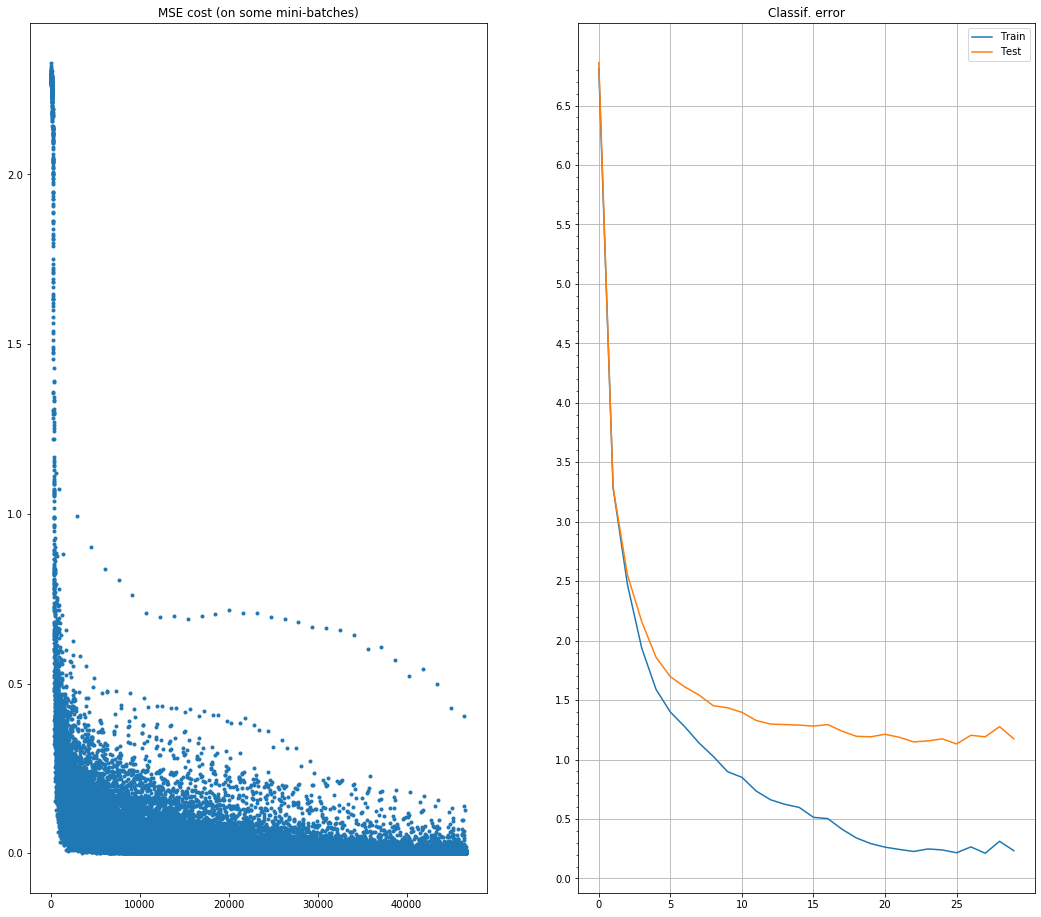

In [46]:
fig = plt.figure(figsize=(18, 16))
plt.subplot(1,2,1)
plt.plot(losses, linestyle='', marker='.')
plt.title('MSE cost (on some mini-batches)')
ax = fig.add_subplot(1, 2, 2)
plt.plot(train_err_rates, label="Train")
plt.plot(test_err_rates, label="Test")
plt.title('Classif. error')
ax.set_xticks(np.arange(0, len(train_err_rates), 5))
ax.set_yticks(np.arange(0, max(test_err_rates), 0.5))
ax.set_yticks(np.arange(0, max(test_err_rates), 0.1), minor=True)
plt.grid()
jnk=plt.legend()

## Display the 12 first errors on the testing set:

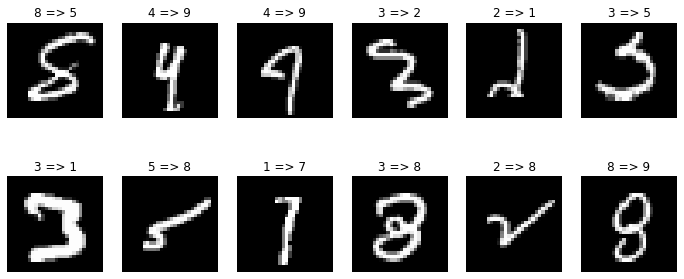

In [49]:
Y_pred = net(X_test)
test_errors_idx = idx_classif_errors( Y_test, Y_pred )[:12]

fig = plt.figure(figsize=(12,8))
ncols = 6
nrows = len(test_errors_idx) // ncols + 1
index = 1
for i in test_errors_idx:
    plt.subplot(nrows, ncols, index)
    plt.imshow( X_test[i].reshape(ImHeight,ImWidth), cmap=plt.cm.gray)
    plt.axis('off')
    true_class = torch.argmax(Y_test[i])
    pred_class = torch.argmax(Y_pred[i])
    plt.title(f'{true_class} => {pred_class}')
    index += 1

    

# Questions 

1. Compute and print the confusion matrix on the training test and on the test set. What classes are confused with each other ?

2. How many parameters (weights) in this network ?

3. After which Epoch should we stop the learning ?
